# **Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo ( A )

---


Aluna(o): Luana Guedes Barros Martins

---

Aluna(o): Ruan Chaves Rodrigues

---

Aluna(o): Thiago Monteles de Souza

---

# Atividade Prática 06 - Processamento de Linguagem Natural

Particionamento das atividades:
- Luana Guedes Barros Martins: Desenvolvedor
- Ruan Chaves Rodrigues: Analista de dados
- Thiago Monteles de Souza: Gerente do Projeto

## Preparação do Ambiente Virtual

In [1]:
!pip install spacy

In [2]:
!python -m spacy download pt_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [3]:
!pip install gensim

In [4]:
!pip install nltk

In [5]:
# Imports

from collections import defaultdict
import numpy as np
from collections import Counter

import pandas as pd

import nltk
import spacy 
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

## Descrição do Problema

Utilizando as técnicas estudadas, será desenvolvido uma ferramenta que permita a comparação de pequenos textos. Devem ser definidas métricas de comparação que classifique os textos segundo critérios de similaridade.

A ferramenta deverá ser aplicada aos Estudos Dirigidos desenvolvidos ao longo do curso de Inteligência Artificial 2019-3. Para cada estudo, deve-se construir uma matriz que mostre a similaridade entre os documentos. Depois, definir um documento de referência e traçar um gráfico de similaridade dos demais em relação a ele.

## Tratamento dos Dados

*Breve descrição do que foi feito*

In [6]:
"""
# Carregar o dataset "baseDeDados.csv" para o ambiente virtual

from google.colab import files
uploaded = files.upload()
"""

'\n# Carregar o dataset "baseDeDados.csv" para o ambiente virtual\n\nfrom google.colab import files\nuploaded = files.upload()\n'

In [7]:
def preprocess(dataframe):
    
    stopwords = nltk.corpus.stopwords.words('portuguese')
    
    nlp = spacy.load("pt_core_news_sm")
    
    docs = pd.read_csv(dataframe, sep=";").astype(str).values.flatten().tolist()
    ids = pd.read_csv(dataframe, sep=";").values
    
    ids = [ [(idx2, idx) for idx,v in enumerate(v2) ] for idx2,v2 in enumerate(ids) ]
    ids = [x for y in ids for x in y ]
    
    docs = [nlp(x) for x in docs]
    docs = [ [ y for y in x if y.is_punct == False and y.text.lower() not in stopwords] for x in docs ]
    
    tokens = [ [ y.lemma_ for y in x ] for x in docs ]
    
    counter = dict(Counter([ x for y in tokens for x in y ]))
    low_freq = [x for x in counter.keys() if counter[x] == 1]
    tokens = [ [ x for x in y if x not in low_freq ] for y in tokens ]
    
    token_docs = [ ' '.join(x) for x in tokens ]
    mydict = corpora.Dictionary([simple_preprocess(line) for line in token_docs])
    nf = len(mydict.dfs)
    
    corpus = [mydict.doc2bow(simple_preprocess(line)) for line in token_docs]
    
    return {
        "nlp": docs,
        "corpus" : corpus,
        "dict": mydict,
        "tokens": tokens,
        "ids" : ids
    }

## Definição do Modelo

Para construir a matriz de similaridade entre os documentos deste trabalho, iremos calcular o valor **TF-IDF** (abreviação do inglês *Term Frenquency - Inverse Document Frequency*, que significa frequência do termo–inverso da frequência nos documentos). 

O TF_IDF é uma medida estatística que indica a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um *corpus*. 

Para calcular o valor TF_IDF multiplica-se a frequência de um termo (TF) pela frequência inversa do documento (IDF). 
- O termo TF mede a frequência de ocorrência de um termo em um documento. Como cada documento é diferente em tamanho, é possível que um termo apareça muito mais vezes em documentos longos do que em documentos mais curtos. Assim, o termo freqüência é freqüentemente dividido pelo tamanho do documento (também conhecido como número total de termos no documento) como forma de normalização.
- O termo IDF mede a importância de um termo. Enquanto computa TF, todos os termos são considerados igualmente importantes. No entanto, certos termos, como "é", "de" e "aquilo", podem aparecer muitas vezes, mas têm pouca importância. 

Assim, temos que:

$$tfidf(i, j, D) = tf(i, j) \cdot idf(i, D)$$

ou

$$tfidf_{i, j} = frequência_{i, j} * log_2\frac{D}{frequênciaDocumento_i}$$

Sendo que:
- $i$ = termo
- $j$ = documento
- $D$ = Número total de documentos


O TF_IDF é calculado com a API [gensim](https://radimrehurek.com/gensim/index.html), utilizando o [models.TfidfModel](https://radimrehurek.com/gensim/models/tfidfmodel.html), onde seus principais métodos são:
- Construtor: calcula que calcula contagens de documentos inversas para todos os termos do corpus de treinamento.
- Método [ ]: transforma uma simples representação de contagem no espaço TfIdf.


Como parâmetro obrigatório, *models.TfidfModel* recebe um *corpus*.


Após calcular o valor TF_IDF será então gerado a matriz de similaridade utilizando-se do [similarities.SparseMatrixSimilarity](https://radimrehurek.com/gensim/similarities/docsim.html#gensim.similarities.docsim.SparseMatrixSimilarity), que dado uma lista de documentos no formato *bag-of-words vector*$^1$ calcula a semelhança de cosseno em um corpo de documentos armazenando a matriz de índice na memória.

In [8]:
def tfidf(preprocess_dict):
    
    # Pega o corpus do conjunto de dados já processados
    corpus = preprocess_dict['corpus']
    

    # Transformação entre co-ocorrência de documento-palavra
    tfidf = models.TfidfModel(corpus)
    
    
    nf = len(preprocess_dict['dict'].dfs)
    
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=nf)
    return {
        "model" : tfidf,
        "index" : index
    }

## Resultados

In [13]:
def get_dataplot(preprocess_dict, model_dict):
    corpus = preprocess_dict['corpus']
    tfidf = model_dict['model']
    index = model_dict['index']
    dataplot = []
    for item in corpus:
        dataplot.append(index[tfidf[item]])
    return pd.DataFrame(dataplot)

def get_graph(preprocess_dict=None, dataplot=None, threshold=None):
    ids = preprocess_dict['ids']
    
    tmp = dataplot.applymap(lambda x: 'nan' if x < threshold else x)
    arr = tmp.values.tolist()
    matches = []
    for idx, item in enumerate(arr):
        for idx2, item2 in enumerate(item):
            if idx != idx2 and arr[idx][idx2] != 'nan':
                matches.append([idx, idx2])
    pairs = [ [ ids[x][0] for x in y ] for y in matches ]
    dict_pairs = dict(Counter([ tuple(x) for x in pairs ])).items()
    G = nx.Graph()
    for item in dict_pairs:
        G.add_edge(*item[0], weight=item[1], length=item[1])
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    nx.draw(G, pos, edges=edges, width=weights, with_labels=True)

In [14]:
data_dict = preprocess("Dados - ED05.csv")
model_dict = tfidf(data_dict)

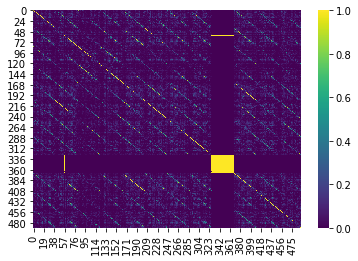

In [15]:
sns.heatmap(get_dataplot(data_dict, model_dict), cmap='viridis')

In [16]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9)

NameError: name 'nx' is not defined

In [ ]:
data_dict = preprocess("Dados - ED06.csv")
model_dict = tfidf(data_dict)

In [ ]:
sns.heatmap(get_dataplot(data_dict, model_dict), cmap='viridis')

In [ ]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9)

In [ ]:
data_dict = preprocess("Dados - ED07.csv")
model_dict = tfidf(data_dict)

In [ ]:
sns.heatmap(get_dataplot(data_dict, model_dict), cmap='viridis')

In [ ]:
get_graph(preprocess_dict=data_dict,
         dataplot=get_dataplot(data_dict, model_dict),
         threshold=0.9)